In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab09.ipynb")

# Lab 9: Bayesian and Frequentist Takes on Multi-Armed Bandits 
Welcome to the ninth DS102 lab! 

The goals of this lab is to implement and gain a better understanding of the pros and cons of the Upper Confidence Bounds (UCB) and Thompson Sampling algorithms for the multi-armed bandits problem.

The code you need to write is indicated by `...`. There is additional documentation for each part as you go along.


## Collaboration Policy 
Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

## Submission
See the [Gradescope Submission Guidelines](https://edstem.org/us/courses/33922/discussion/2419862) for details on how to submit your lab.

**For full credit, this assignment should be completed and submitted before Friday, April 14th, 2023 at 11:59 PM PDT.**

## Collaborators 
Write the names of your collaborators in this cell.

`<Collaborator Name> <Collaborator e-mail>`

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from matplotlib.widgets import Button, CheckButtons
from matplotlib import gridspec
import functools
from Bandit_env import BanditEnv, Interactive_UCB_Algorithm,Interactive_TS_Algorithm

%load_ext autoreload
%autoreload 2
%matplotlib widget

# Multi-Armed Bandits (MAB)

In this lab we will be implementing two of the most common approaches to solving stochastic Multi-Armed Bandit (MAB) problems. We first define the problem and then you will have a chance to implement the Upper Confidence Bound (UCB) algorithm and the Thompson Sampling (TS) algorithm from lecture and analyze their performance.

Recall that MABs are useful when we are making sequential decisions with feedback: each decision is between several choices (which we'll call arms), and when we make a decision, we get some feedback that we'll use to make good decisions in the future.

## Problem Setting: 

A MAB problem is a simple setting in which it is easy to analyze the __exploration/exploitation__ tradeoff that is extremely common in online machine learning. The setup is as follows:

A MAB instance is a set $\mathcal{A}$ of $K$ arms (these represent different choices that we can make). Each arm $a \in \mathcal{A}$ is associated with a reward distribution $X_a \sim p_a$ which is unique to that arm. The mean of an arm $a \in \mathcal{A}$ is denoted as $\mu_a=\mathbb{E}[X_a]$. 

At each time $t=1,2,...$, an algorithm that is interacting with a MAB must choose an arm, $A_t \in \mathcal{A}$. The algorithm then receives a reward $X_{A_t}^{(t)}$ sampled independently from $\mathbb{P}_{A_t}$.

The __goal__ of an algorithm interacting with a MAB instance is to find the arm $A^\ast$ with the highest mean reward $\mu^\ast$ as fast as possible while maintaining performance. That is, it would like to find the single optimal arm $A^\ast$ such that:

$$ A^\ast=arg\max_{a \in \mathcal{A}} \mu_a$$

where $\mu^*=\mu_{A^\ast}$.

This is often encoded as wanting to find an algorithm that minimizes the __pseudoregret__ over a time horizon $T$. Intuitively, the pseudoregret is the best the algorithm could have done in hindsight, **on average**, if it had known which was the optimal arm ($A^*$). In order to simplify our analysis and focus on getting to the arm with the highest mean, we're interested in this quantity "on average": in other words, our definition of regret will not be concerned with the randomness in the reward distributions themselves.

$$ \bar{R}_T= \sum_{t=1}^T \mu_{A^\ast} - \mu_{A_t}$$

Even though we're ignoring the randomness in the reward distributions and only looking at the means, the pseudoregret $\bar{R}_T$ is still random! This is because our decisions $A_t$ are dependent on what rewards we observed from 1 to $t-1$. 

It is often simpler to analyze the regret, which is the expectation of the pseudoregret:

$$ R_T= T \mu^* - \mathbb{E}\left[\sum_{t=1}^T \mu_{A_t}\right]$$

### Lab setup: 

In this lab, the MAB instances will have a set of arms numbered $0,1,...,K-1$. Each arm $a=0,1,...,K-1$ is associated with a Gaussian reward distribution with mean $\mu_a$ and standard deviation of $\sigma_a=1.5$. To be able to analyze the various algorithms, the optimal arm $A^\ast$ will always be arm $0$, and its mean will always be $\mu^\ast=10$.

By running the following cells, you can interact with a MAB instance of the type we will be using in this lab. You can see the reward distributions as well as the expected cumulative regret you incur when pulling each arm. 

Verify for yourself that explore-then-commit strategies can get stuck pulling the wrong arm.

In [3]:
# Run this cell to initialize the parameters for the arms that we will be pulling from.

# Mean reward for each arm. Arm 0 has the highest mean, but the algorithm doesn't know that yet.
means=[10,9,8,7,6,4]

# Variance of the reward for each arm.
variance=1.5
standard_deviations=[np.sqrt(variance) for arm in range(len(means))]

# Initialize the interactive environment for pulling arms.
bandit_env=BanditEnv(means,standard_deviations)

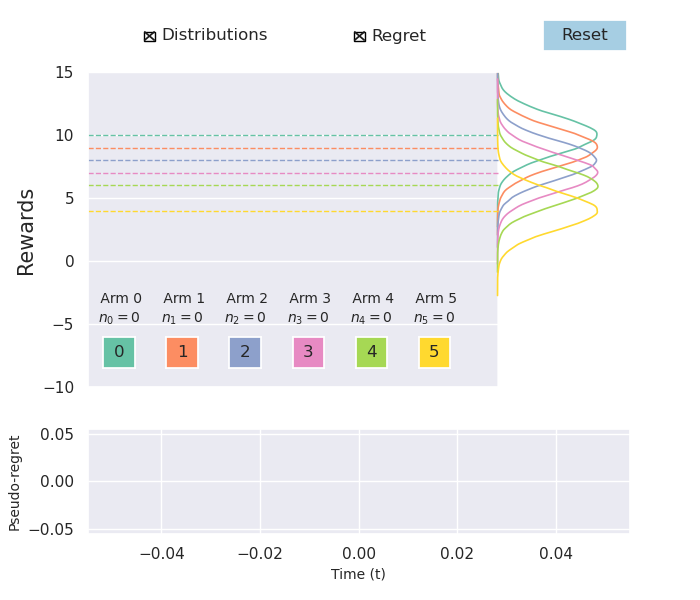

In [4]:
"""
Creates an interactive bandit instance.

    - Pull an arm by clickling on the colored button
    - The true means of the distributions are shown with the dashed horizontal lines
    - Large solid circle is the sample mean of the arm
    - Small empty circle is a sample from the arm
    - The reward distribution of each arm is shown on the right and can be toggled on/off by checking the box
    - Running Pseudo-regret is shown on the bottom and can be toggled on/off by checking the box
"""

%matplotlib widget

# You may need to rerun this cell to restart the gui

plt.rcParams['figure.figsize']=[7,6]
bandit_env.run_Interactive()

# You can click on the arms to see how it selecting sub-optimal arms accumulates regret

# Part 1.  The Frequentist Approach: Upper Confidence Bounds (UCB) 

The first algorithm we will analyze is the frequentist take on multi-armed bandits, known as the Upper Confidence Bounds (UCB) algorithm. 

For each arm $a \in \{ 0,1,...,K-1\}$, you keep track of:

1. $T_a(t)$: the number of times arm $a$ has been pulled up to and including iteration $t$.
2. $X_{a}^{(1)},...,X_{a}^{(T_a(t))}$: the samples you have received from arm $a$. Let $\hat \mu_{a,T_a(t)}$ be the mean of those samples: $\hat \mu_{a,T_a(t)} = \frac{1}{T_a(t)}\sum_{i=1}^{T_a(t)}X_{a}^{(i)}$

Using this information, you compute an upper confidence bound, $C_a(T_a(t),\delta)$ that encompasses the true mean $\mu_a$ with probability at least $1-\delta$, for some $\delta \in [0,1]$. $C_a(T_a(t),\delta)$, must therefore satisfy:

$$ \mathbb{P}\bigg(\mu_a < \hat \mu_{a,T_a(t)} + C_a(T_a(t),\delta)\bigg) > 1 - \delta.$$

As an edge case, after $0$ samples, we simply set the upper bound on $\mu_a$ to $\infty$, since it's always true that $\mathbb{P}(\mu_a < \infty) > 1 - \delta$.

The algorithm then pulls, at each round $t$, the arm with the highest upper confidence bound based on the results we saw up to time $t-1$:

$$ A_t=\underset{a \in \{ 0,1,...,K-1\}}{\operatorname{argmax}} \hat\mu_{a,T_a(t-1)} + C_a(T_a(t-1),\delta).$$

## The UCB algorithm
We will now implement the classic version of the UCB algorithm using the Hoeffding bound that we derived in lecture.

In lecture, we used the Hoeffding bound for the sample mean of bounded random variables. Here instead we will use a related bound for the sample mean of normally distributed random variables. The sample mean of Gaussian random variables $X_{a}^{(1)},...,X_{a}^{(T_a(t))}$, $X_a^{(i)} \sim \mathcal{N}(\mu_a, \sigma_a)$, satisfies the following form of the Hoeffding Inequality:

$$ P( \hat \mu_{a,T_a(t)}-\mu_a \leq -\epsilon) \leq \exp\left( -\frac{T_a(t)\epsilon^2}{2\sigma_a^2}\right).$$

*Take a minute to compare this bound with the bounds discussed in lecture.*

This bound results in the upper confidence bound on $\mu_a$:

$$P\left(\mu_a <\hat \mu_{a,T_a(t)} + \sigma_a\sqrt{\frac{2\log{1/\delta}}{T_a(t)}}\right)> 1-\delta. $$

where $\hat\mu_{a,T_a(t)}$ is the current sample mean for arm $a$:

$$ \hat\mu_{a,T_a(t)} =\frac{1}{T_a(t)} \sum_{i=1}^{T_a(t)} X_{a}^{(i)}$$

and the confidence bound term added to $\hat\mu_{a,T_a(t)}$ is:
$$C_a(T_a(t),\delta) = \sigma_a\sqrt{\frac{2\log{1/\delta}}{T_a(t)}}.$$

To handle the edge case where we've seen $0$ samples from arm $a$ so far (i.e. $T_a(t-1) = 0$), we set the upper bound on $\mu_a$ to $\infty$. Specifically, we set

$$ C_a(T_a(t),\delta) = \begin{cases} \infty \  &\text{ if } T_a(t)=0 \\  \sigma_a\sqrt{\frac{2\log{1/\delta}}{T_a(t)}} \ \ \ \ \ \  &\text{ if } T_a(t)>0\end{cases}$$
and 
$$ \hat\mu_{a,T_a(t)} = \begin{cases} \infty \  &\text{ if } T_a(t)=0 \\  \frac{1}{T_a(t)} \sum_{i=1}^{T_a(t)} X_{a}^{(i)} \ \ \ \ \ \  &\text{ if } T_a(t)>0\end{cases}$$

Finally, as mentioned earlier, we choose the arm $A_t$ at time $t$ as follows:

$$ A_t=\underset{a \in \{ 0,1,...,K-1\}}{\operatorname{argmax}} \hat\mu_{a,T_a(t-1)} + C_a(T_a(t-1),\delta).$$

We will choose a $\delta$ that decreases with time to ensure that we will explore the arms at first: 
$$ \delta=\frac{1}{t^3}$$

## Question 1: 

Now, use this formula for $A_t$ to fill out the following function which returns the choice of arm as well as the upper confidence bounds of each arm. In the code below, we use the variable `c_bound` to refer to the entire term $\hat\mu_{a,T_a(t)} + C_a(T_a(t),\delta)$.


In [24]:
def UCB_pull_arm(t, standard_deviations, times_pulled, rewards):
    """ Implement the choice of arm for the UCB algorithm
    
    Inputs:
        t : int, current iteration
        standard_deviations : a list of length K (where K is the number of arms) of the 
            standard deviations associates with each arm
        times_pulled: a list of length K (where K is the number of arms) of the number 
            of times each arm has been pulled.
        rewards: a list of K lists. Each of the K lists holds the samples received from
            pulling each arm up to iteration t. 

    Outputs:
        arm: an integer representing the arm that the UCB algorithm would choose.
        confidence_bounds: a list of the confidence bounds for each arm
    """

    K = len(times_pulled)
    delta = 1/(t**3)
    
    confidence_bounds=[]
    for arm in range(K):
        if times_pulled[arm]==0:
            c_bound = np.inf
        else:
            c_bound = np.mean(rewards[arm]) + standard_deviations[arm] * np.sqrt(2 * np.log(1 / delta) / times_pulled[arm])
            
        confidence_bounds.append(c_bound)
            
    arm = np.argmax(confidence_bounds)
    
    return arm, confidence_bounds

In [25]:
grader.check("q1")

q1 results: All test cases passed!

Here is a cell for testing with a simple example:

In [26]:
times_pulled_test = [3, 5, 7, 4, 0]
t_test = np.sum(times_pulled_test) + 1
standard_deviations_test = [0.4, 0.2, 0.1, 0.2, 0.3]
rewards_test = [[10.4, 10.6, 11], 
                [8, 13, 12, 11, 9], 
                [9, 10, 10, 8, 9.5, 10.5, 11],
                [8.3, 9.6, 7.9, 8.1],
                []]
test_arm, test_confidence_bounds = UCB_pull_arm(t_test, standard_deviations_test, times_pulled_test, rewards_test)

print(test_arm)
print(test_confidence_bounds)

4
[11.645765398938993, 10.97920330843835, 9.874528359052615, 8.898962187480487, inf]


### UCB Regret
Given the function you have filled out, let us investigate the regret of the UCB algorithm.  Since the regret is an expectation of the pseudo-regret, the following cell runs the algorithm $20$ times and computes the average pseudo-regret across all runs at each time step.

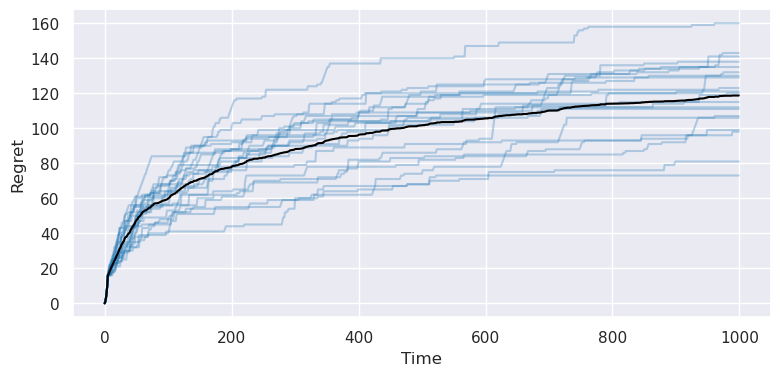

In [27]:
%matplotlib inline

#Initialize Figure
plt.rcParams['figure.figsize']=[9,4]
plt.figure()

# Define the time horizon of each run, and the number of runs of each the algorithm.
T=1000
num_runs=20

#Initialize pseudo-regret
UCB_pseudo_regret=np.zeros([T, num_runs])
for run in range(num_runs):
    #Initialize Bandit_environment
    bandit_env.initialize(make_plot=0)
    for t in range(1,T+1):
        #Choose arm using UCB algorithm
        arm,confidence_bounds=UCB_pull_arm(t, standard_deviations, bandit_env.times_pulled,bandit_env.rewards)
        
        #Pull Arm
        bandit_env.pull_arm(arm)
        
    #Keep track of pseudo-regret for each run
    UCB_pseudo_regret[:, run] = np.array(bandit_env.regret[1:])

#Make plot

#First, plot the pseudoregret from each run so we can see how it varies
plt.plot(UCB_pseudo_regret, color='tab:blue', alpha=0.3)

#Then, plot our estimate of the regret (average pseudo-regret)
UCB_regret = np.mean(UCB_pseudo_regret, axis=1)
plt.plot(UCB_regret, color='black')

plt.xlabel('Time')
plt.ylabel('Regret')
plt.show()

### Visualize Your Algorithm
If you want to visualize your algorithm, you can use the following interactive demo (If it is lagging, do not worry this part is not graded and is meant to build your intuition for the algorithm):

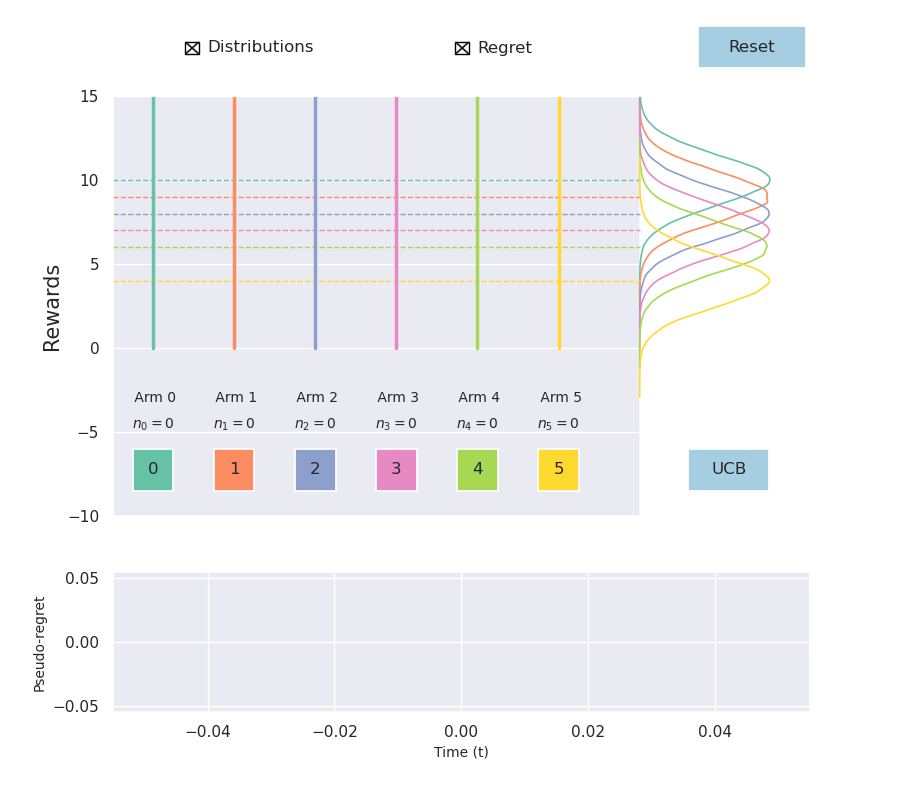

In [28]:
%matplotlib widget

plt.rcParams['figure.figsize']=[9,8]

"""
Creates an interactive bandit instance with an option to test your algorithm.
    - Pull an arm by clickling on the colored button
    - Allow your algorithm to choose the arm by clicking on the ``UCB'' button in the lower right.
    - The true means of the distributions are shown with the dashed horizontal lines
    - Large solid circle is the sample mean of the arm
    - Solid vertical line is the upper confidence bound you have calculated
    - The reward distribution of each arm is shown on the right and can be toggled on/off by checking the box
    - Running Pseudo-regret is shown on the bottom and can be toggled on/off by checking the box
"""


# You may need to rerun this cell to restart the gui
alg=Interactive_UCB_Algorithm(bandit_env,UCB_pull_arm,'UCB')
alg.run_Interactive_Alg()

# Part 2: The Bayesian Approach with Thompson Sampling 
Next, we will analyze the Bayesian take on multi-armed bandits, known as Thompson Sampling. In this setting, we would treat the mean as a *random* variable, instead of a fixed, hidden one. This allows to begin with a prior over the mean of each arm $\mu_a \sim \pi_a$.

In an ideal world, at each round $t=1,2...$, we would like an algorithm that computes the posterior probability $q_{a,t}$ that arm $a\in \mathcal{A}$ has the highest mean reward.

$$q_{a,t}=\mathbb{P}\bigg(\mu_a=\max_{a'} \mu_{a'} \ \bigg| \ X_{1,A_1},...,X_{t-1,A_{t-1}}\bigg).$$

In this scenario, the choice of arm would then be randomly sampled from the distribution $q_t$ over $\mathcal{A}$, where each arm $a\in \mathcal{A}$ has probability $q_{a,t}$:

$$ A_t \sim q_t $$ 

## Implementing Thompson Sampling

However, in practice, the posterior distribution above is often intractable to compute. Instead, we'll implement a simpler algorithm (the one from lecture) that nevertheless accomplishes the same task.

At each round $t=1,2....$, you keep track of the posterior distribution over $\mu_a$, for each arm $a \in \{ 0,1,...,K-1\}$,  given all the samples you have observed from that arm $X_{a,1},...,X_{a,T_a(t-1)}$. Denote by $p_{a,t}$ the posterior distribution of the mean reward associated with arm $a$, after observing all the samples up to time $t$.

$$p_{a,t}=\mathbb{P}(\mu_a | X_{a,1},...,X_{a,T_a(t-1)}).$$

You then take one posterior sample from $p_{a,t}$ and choose the arm with the highest sample:

1. $\tilde\mu_{a,t} \sim  p_{a,t}$ for $a \in \{0,1,...,K-1\}$.
2. Choose arm:
$$ A_t=\underset{a \in \{ 0,1,...,K-1\}}{\operatorname{argmax}} \tilde\mu_{a,t}$$

Since the reward distributions in this lab are Gaussians with known variance $\sigma_a^2$, we know from our investigation of conjugate priors that if we have Gaussian priors: $\mu_a\sim\mathcal{N}(\mu_{a,0},\sigma_{a,0}^2)$, and Gaussian likelihoods $X_a^{(i)}|\mu_a \sim \mathcal{N}(\mu_a, \sigma_a)$ the posterior distribution for each arm will also be a Gaussian. 

Therefore, to implement Thompson Sampling in this lab, the posterior distributions for each arm in this lab at each time $t=1,2,...$ are given by:

$$ p_{a,t}=\mathcal{N}(\hat\mu_{a,t},\hat{\sigma}_{a,t}^2)$$

where,
 $$\hat{\sigma}_{a,t}^2 =\bigg(\frac{1}{\sigma_{a,0}^2}+\frac{T_a(t-1)}{\sigma_a^2}\bigg)^{-1} $$
$$ \hat\mu_{a,t}=\hat{\sigma}_{a,t}^2 \bigg( \frac{\mu_{a,0}}{\sigma_{a,0}^2}+\frac{\sum_{i=1}^{T_a(t-1)} X_{a,i}}{\sigma_a^2} \bigg)$$

## Question 2b:

Fill out the following function that implements the choice of arm for the Thompson Sampling algorithm with Gaussian arms and prior.

In [29]:
def TS_pull_arm(t,variances,times_pulled,rewards,prior_means,prior_variances):
    """ 
    Implement the choice of arm for the Thompson Sampling Algorithm when the arms and priors are Gaussians.
    
    Inputs:
        t: int, number of iteration of the bandit algorithm.
        variances: a list of length K (where K is the number of arms) of the variances
            corresponding to each arm (\sigma_a^2 in the likelihood expression above)
        times_pulled: a list of length K of the number of times each arm has been pulled.
        rewards: a list of K lists. Each of the K lists holds the samples received from pulling each arm up 
            to iteration t.
        prior_means: a list of length K with the mean of the priorsfor each arm.
        prior_mea: a list of length K with the variance of the prior for each arm.
    
    Outputs:
        arm: integer representing the arm that the TS algorithm would choose.
        posterior_samples: list of samples from the posterior used to choose the arm. 
        posterior_means: list of means of the posterior for each arm
        posterior_vars: list of variances of the posteriors of each arm
    """

    K=len(times_pulled)
    
    posterior_samples=[]
    posterior_means=[]
    posterior_vars=[]
    for arm in range(K):
        
        # TODO: fill in arm_var_hat, which is \hat\sigma^2_{a,t}.
        # Hint: \hat\sigma^2_{a,0} is prior_variances[arm], \sigma^2_a is variance,
        arm_var_hat = 1.0 / (1.0 / prior_variances[arm] + times_pulled[arm] / variances[arm])
        
        # TODO: fill in mean_hat, which is \hat\mu_{a,t}.
        # Hint: \mu_{a,0} is prior_means[arm], and X_a^{(i)} is rewards[arm] (as before).
        mean_hat = arm_var_hat * (prior_means[arm] / prior_variances[arm] + np.sum(rewards[arm]) / variances[arm])
        
        posterior_samples.append(np.random.normal(mean_hat,arm_var_hat))
        posterior_means.append(mean_hat)
        posterior_vars.append(arm_var_hat)
            
    arm = np.argmax(posterior_samples)
    
    return arm, posterior_samples, posterior_means, posterior_vars

In [30]:
grader.check("q2")

q2 results: All test cases passed!

Here is a cell for testing with a simple example:

In [31]:
times_pulled_test = [3, 5, 7, 4, 1]
prior_means_test=[8,5,7,9,6]
prior_variances_test=[2.5, 0.1, 1.6, 2.3, 1.7]
t_test = np.sum(times_pulled_test) + 1
variances_test = [0.4, 0.2, 0.1, 0.2, 0.5]
rewards_test = [[10.4, 12.6, 11], 
                [8, 13, 12, 11, 9], 
                [9, 10, 10, 8, 9.5, 10.5, 11],
                [8.3, 9.6, 7.9, 8.1],
                [8]]
test_arm, posterior_samples_test, posterior_means_test, posterior_vars_test = TS_pull_arm(t_test, 
                                                                                          variances_test, 
                                                                                          times_pulled_test, 
                                                                                          rewards_test,
                                                                                          prior_means_test,
                                                                                          prior_variances_test)


print("means:")
print(posterior_means_test)
print("variances:")
print(posterior_vars_test)
print("samples:")
print(posterior_samples_test)
print("arm pulled: " + str(test_arm))

means:
[11.164556962025316, 9.0, 9.690265486725664, 8.486170212765957, 7.545454545454546]
variances:
[0.12658227848101264, 0.02857142857142857, 0.01415929203539823, 0.04893617021276596, 0.38636363636363635]
samples:
[11.322726388507558, 8.998205548684728, 9.696894953642555, 8.446605417171279, 7.864718644151709]
arm pulled: 0


## Thompson Sampling with Good Priors
As we saw in class, the performance of Thompson Sampling can vary drastically with the quality of the prior. 

First, let us analyze the performance of Thompson Sampling when the priors reflect the correct rankings of the arms (meaning that the prior mean for arm $0$ is the highest). We will compare it to the performance of the UCB algorithm.

In [ ]:
%matplotlib inline

# No TODOs here, just run the code and inspect the plot
#Initialize Figure
plt.rcParams['figure.figsize']=[9,4]
plt.figure()

# Variance of the reward for each arm.
variance=1.5
true_variances=[variance for arm in range(len(means))]

#Define Prior Means and Variances
prior_means=[12,9,8,7,4,3]
prior_vars=[3.2,3.2,3.2,3.2,3.2,3.2]


#Initialize pseudo-regret
TS_pseudo_regret=np.zeros([T, num_runs])
for run in range(num_runs):
    #Initialize bandit environment
    bandit_env.initialize(make_plot=0)
    for t in range(1,T+1):
        #Choose arm with Thompson Sampling
        arm,samples,means,variances=TS_pull_arm(t,true_variances,bandit_env.times_pulled,bandit_env.rewards,prior_means,prior_vars)
        
        #Pull Arm
        bandit_env.pull_arm(arm)
    
    #Keep track of regret Regret
    TS_pseudo_regret[:, run] = np.array(bandit_env.regret[1:])

#Make plot

#First, plot the UCB regret and pseudo-regret
plt.plot(UCB_pseudo_regret, color='tab:blue', alpha=0.3)
plt.plot(UCB_regret, color='blue', label='UCB Regret')

#Then, plot Thompson Sampling regret and pseudo-regret
plt.plot(TS_pseudo_regret, color='tab:red', alpha=0.1)
TS_regret = np.mean(TS_pseudo_regret, axis=1)
plt.plot(TS_regret, color='red', label='TS Regret')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Regret')
plt.show()

## Thompson Sampling with Bad Priors
Now let us analyze the performance of Thompson Sampling when the priors have completely incorrect correct rankings of the arms, meaning that the prior mean for arm $0$ is the lowest.

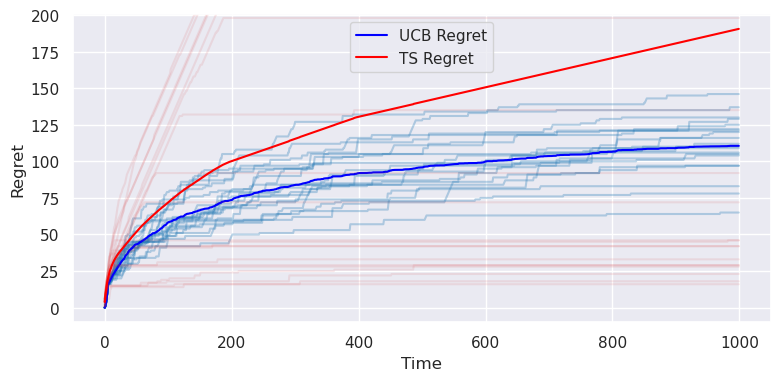

In [14]:
%matplotlib inline

# No TODOs here, just run the code and inspect the plot
#Initialize Figure
plt.rcParams['figure.figsize']=[9,4]
plt.figure()

#Define prior means and standard deviations
prior_means=[2,3,4,5,6,7]
prior_vars=[3.2,3.2,3.2,3.2,3.2,3.2]

#Initialize pseudo-regret
TS_pseudo_regret=np.zeros([T, num_runs])
for run in range(num_runs):
    #Initialize bandit environment
    bandit_env.initialize(make_plot=0)
    for t in range(1,T+1):
        #Choose arm with Thompson Sampling
        arm,samples,means,variances=TS_pull_arm(t,true_variances,bandit_env.times_pulled,bandit_env.rewards,prior_means,prior_vars)
        
        #Pull Arm
        bandit_env.pull_arm(arm)
    
    #Keep track of regret Regret
    TS_pseudo_regret[:, run] = np.array(bandit_env.regret[1:])

#Make plot

#First, plot the UCB regret and pseudo-regret
plt.plot(UCB_pseudo_regret, color='tab:blue', alpha=0.3)
plt.plot(UCB_regret, color='blue', label='UCB Regret')

#Then, plot Thompson Sampling regret and pseudo-regret
plt.plot(TS_pseudo_regret, color='tab:red', alpha=0.1)
TS_regret = np.mean(TS_pseudo_regret, axis=1)
plt.plot(TS_regret, color='red', label='TS Regret')

plt.legend()
plt.xlabel('Time')
plt.ylim(-10, max(TS_regret) + 10)
plt.ylabel('Regret')
plt.show()

## Thompson Sampling with the same prior for each arm 
Now let us analyze the performance of Thompson Sampling when the priors are the same for all arms.

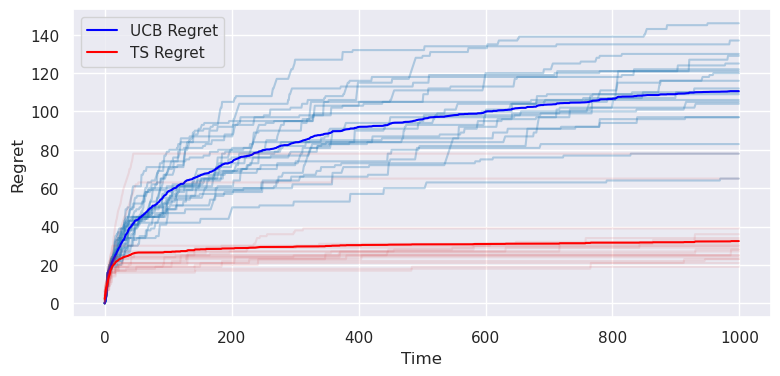

In [15]:
%matplotlib inline

# No TODOs here, just run the code and inspect the plot
plt.rcParams['figure.figsize']=[9,4]
plt.figure()

#Define prior means and variances
prior_means=[8,8,8,8,8,8]
prior_vars=[2.5,2.5,2.5,2.5,2.5,2.5]

#Initialize pseudo-regret
TS_pseudo_regret=np.zeros([T, num_runs])
for run in range(num_runs):
    #Initialize bandit environment
    bandit_env.initialize(make_plot=0)
    for t in range(1,T+1):
        #Choose arm with Thompson Sampling
        arm,samples,means,variances=TS_pull_arm(t,true_variances,bandit_env.times_pulled,bandit_env.rewards,prior_means,prior_vars)
        
        #Pull Arm
        bandit_env.pull_arm(arm)
    
    #Keep track of regret Regret
    TS_pseudo_regret[:, run] = np.array(bandit_env.regret[1:])

#Make plot

#First, plot the UCB regret and pseudo-regret
plt.plot(UCB_pseudo_regret, color='tab:blue', alpha=0.3)
plt.plot(UCB_regret, color='blue', label='UCB Regret')

#Then, plot Thompson Sampling regret and pseudo-regret
plt.plot(TS_pseudo_regret, color='tab:red', alpha=0.1)
TS_regret = np.mean(TS_pseudo_regret, axis=1)
plt.plot(TS_regret, color='red', label='TS Regret')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Regret')
plt.show()

### Visualize Your Algorithm 
If you want to visualize your algorithm, you can use the following interactive demo (If it is lagging, do not worry this part is not graded and is meant to build your intuition for the algorithm):

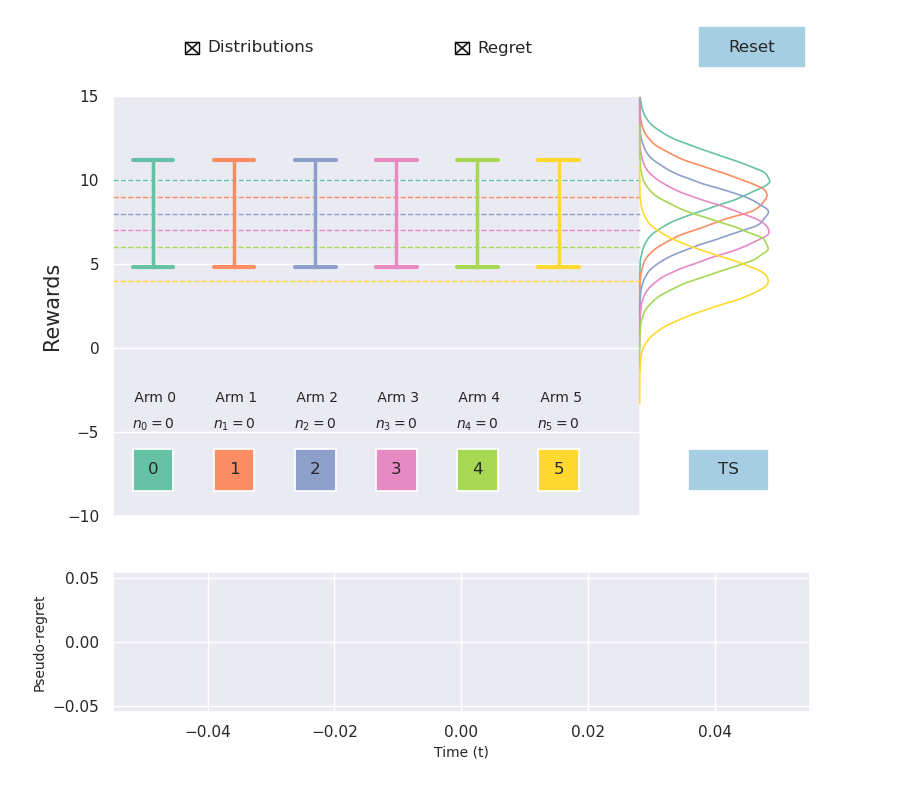

In [16]:
%matplotlib widget

plt.rcParams['figure.figsize']=[9,8]

"""
Creates an interactive bandit instance with an option to test your algorithm.
    - Pull an arm by clickling on the colored button.
    - Allow your algorithm to choose the arm by clicking on the ``TS'' button in the lower right.
    - The true means of the distributions are shown with the dashed horizontal lines.
    - Large solid circle is the sample mean of the rewards for the arm.
    - Solid vertical line shows the 95% credible interval for the arm.
    - The reward distribution of each arm is shown on the right and can be toggled on/off by checking the box.
    - Running Pseudo-regret is shown on the bottom and can be toggled on/off by checking the box.
"""

#Define prior means and variances
prior_means=[8,8,8,8,8,8]
prior_vars=[2.5,2.5,2.5,2.5,2.5,2.5]

# You may need to rerun this cell to restart the gui
alg=Interactive_TS_Algorithm(bandit_env,TS_pull_arm,'TS',prior_means,prior_vars)
alg.run_Interactive_Alg()

<!-- BEGIN QUESTION -->

## Question 3: Pros and Cons of UCB and Thompson Sampling

In the following cell, write a few sentences comparing and contrasting UCB and Thompson Sampling. What are some pros and cons of UCB and of Thompson Sampling?

UCB relies on an upper confidence bound to balance exploration and exploitation, while Thompson Sampling uses probability distributions to model the uncertainty about the rewards of each arm.

UCB has a guaranteed theoretical bound on its performance, but it can struggle in more complex scenarios. Thompson Sampling, on the other hand, has no theoretical guarantees but can adapt well to changing environments and perform better in complex scenarios.

A disadvantage of UCB is that it can be sensitive to the choice of parameters and assumptions about the distribution of rewards. Thompson Sampling, on the other hand, can be computationally expensive and may require a large number of samples to accurately estimate the posterior distributions.

Overall, both algorithms have their strengths and weaknesses, and the choice of which algorithm to use depends on the specific problem at hand.

<!-- END QUESTION -->



Yay, you've made it to the end of Lab 9!


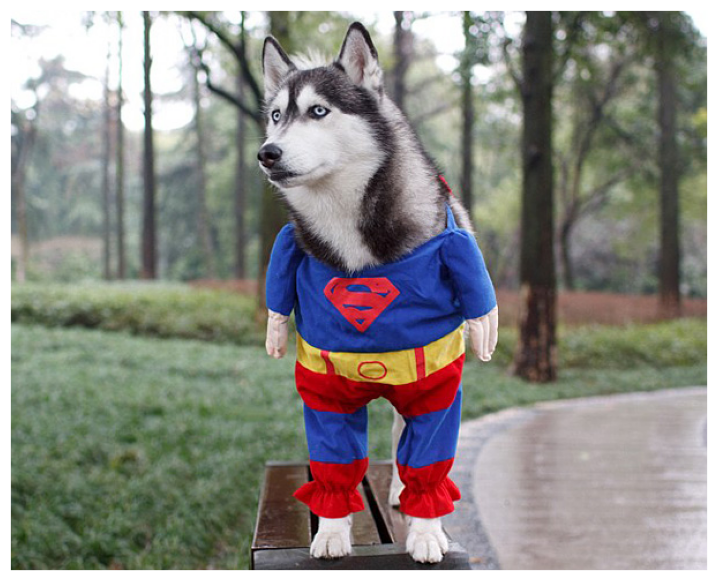

In [17]:
%matplotlib inline
import matplotlib.image as mpimg
img = mpimg.imread('its_arms.jpeg')
imgplot = plt.imshow(img)
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)
print("Yay, you've made it to the end of Lab 9!")
plt.show()

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [18]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...



Your submission received the following results when run against available test cases:

    q1 results: All test cases passed!

    q2 results: All test cases passed!
